In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.stats import binned_statistic
import healpy as hp

from scipy.constants import c as speed_of_light

def bin_centers_function(edges):
    cents = list()
    for i in range(len(edges)-1):
        cents.append((edges[i+1]+edges[i])/2)
    return np.array(cents)

In [2]:
dataLF = np.loadtxt("../Data/SMmatching/LF_Ser.dat")
# In https://arxiv.org/pdf/1304.7778.pdf h=0.7. Convert to preferred hubble units.
xLF = dataLF[:, 0]
yLF = dataLF[:, 1]

In [3]:
catalog = fits.open("../BAM/Old/nsa_v1.fits")[1].data

def absmag2appmag_kcorrection(M, comoving_distance, redshift, Kcorr):
    luminosity_distance = (1+redshift)*comoving_distance
    return M+25+5*np.log10(luminosity_distance)+Kcorr

# Unpack the catalog, correct for h later. For now assume h=1 to get the right appmag limit
dist = catalog['ZDIST']*speed_of_light*1e-3/(100)
Z = catalog['Z']
RA = catalog['RA']
DEC = catalog['DEC']
Mr = catalog['SERSIC_ABSMAG'][:, 4]
Kcorr = catalog['SERSIC_KCORRECT'][:, 4]

# Take only objects with a finite Mr estimate
IDS = np.where(np.isfinite(Mr))

dist = dist[IDS]
Mr = Mr[IDS]
RA = RA[IDS]
DEC = DEC[IDS]
Z = Z[IDS]
Kcorr = Kcorr[IDS]

# Make a cut on apparent magnitude
appMr = absmag2appmag_kcorrection(Mr, dist, Z, Kcorr)
# IDS = np.where(np.logical_and(14.5 < appMr, appMr < 17.7))
IDS = np.where(appMr < 17.6)

dist = dist[IDS]
Mr = Mr[IDS]
RA = RA[IDS]
DEC = DEC[IDS]
Z = Z[IDS]
Kcorr = Kcorr[IDS]
appMr = appMr[IDS]

# And convert everything into correct units of h
h = 0.7 # consistent with bernardi
dist = dist/h
Mr = Mr - 5*np.log10(h)

# Make a volume-limited catalog
dist_max = 175
IDS = np.where(dist < dist_max)
dist = dist[IDS]
Mr = Mr[IDS]
RA = RA[IDS]
DEC = DEC[IDS]

# Take only some portion of the sky to have a well defined survey volume
RAmin, RAmax = 120, 240
DECmin, DECmax = 0, 60
IDS1 = np.where(np.logical_and(RA>RAmin, RA<RAmax))
IDS2 = np.where(np.logical_and(DEC>DECmin, DEC<DECmax))
IDS = np.intersect1d(IDS1, IDS2)
dist = dist[IDS]
Mr = Mr[IDS]
RA = RA[IDS]
DEC = DEC[IDS]

volume = np.deg2rad(RAmax-RAmin)*(np.sin(np.deg2rad(DECmax))-np.sin(np.deg2rad(DECmin)))*1/3*dist_max**3

In [4]:
bin_width = 0.2
bins = np.arange(-24.7, -17, bin_width)

stat, __, __ = binned_statistic(Mr, Mr, statistic='count', bins=bins)
bin_centers = bin_centers_function(bins)

LF_volume_lim = stat/bin_width/volume

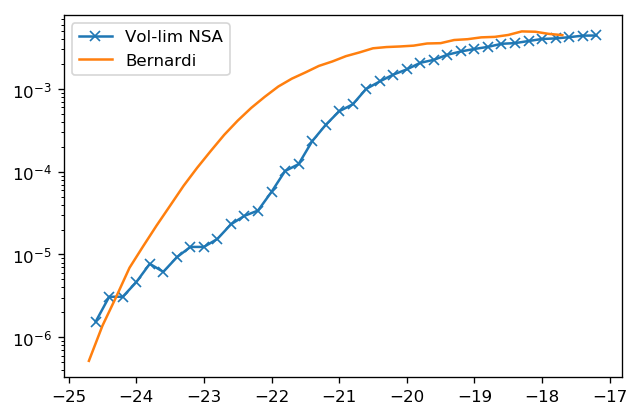

In [5]:
plt.figure(dpi=120)
plt.semilogy(bin_centers, LF_volume_lim, marker='x', label='Vol-lim NSA')
plt.semilogy(xLF, 10**yLF, label='Bernardi')
plt.legend()
plt.show()